In [1]:
using Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/GitHub/dynamics-simulation-16-715/lecture-notebooks/Lecture 19/Project.toml`


In [2]:
using LinearAlgebra
using ForwardDiff
using Plots

In [3]:
#Parameters
m1 = 1.0
m2 = 1.0
J1 = Diagonal([0.1; 1.0; 1.0])
J2 = Diagonal([0.1; 1.0; 1.0])
ℓ1 = 1.0
ℓ2 = 1.0

1.0

In [4]:
M̄ = [m1*I(3) zeros(3,9);
     zeros(3,3) J1 zeros(3,6);
     zeros(3,6) m2*I(3) zeros(3,3);
     zeros(3,9) J2]

12×12 SparseArrays.SparseMatrixCSC{Float64, Int64} with 12 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   0.1   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   0.1   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

In [5]:
function hat(ω)
    return [0 -ω[3] ω[2];
            ω[3] 0 -ω[1];
            -ω[2] ω[1] 0]
end

function L(Q)
    [Q[1] -Q[2:4]'; Q[2:4] Q[1]*I + hat(Q[2:4])]
end

function R(Q)
    [Q[1] -Q[2:4]'; Q[2:4] Q[1]*I - hat(Q[2:4])]
end

H = [zeros(1,3); I];

T = Diagonal([1.0; -1; -1; -1])

function G(Q)
    return L(Q)*H
end

function Ḡ(q)
    Q = q[4:7]
    return [I(3) zeros(3,4); zeros(4,3) G(Q) zeros(4,1); zeros(1,6) 1]
end

function G̃(q)
    Q = q[4:7]
    #return [I(3) zeros(3,4); zeros(4,3) G(Q) zeros(4,1); zeros(1,6) 1]
    return [I(3) zeros(3,4); zeros(4,3) 0.5*G(Q) zeros(4,1); zeros(1,6) 1]
end

G̃ (generic function with 1 method)

In [11]:
#Kinematics
function kinematics(q)
    r0 = q[1:3]
    Q0 = q[4:7]
    q1 = q[8]
    
    #H'*L(q)*R(q)'*H
    
    Q1 = L(Q0)*[cos(q1/2); 0; 0; sin(q1/2)]
    r1 = r0 + H'L(Q0)*R(Q0)'*H*[0.5*ℓ1; 0; 0] + H'L(Q1)*R(Q1)'*H*[0.5*ℓ2; 0; 0]
    
    return [r0; Q0; r1; Q1]
end

kinematics (generic function with 1 method)

In [12]:
#Kinematic Jacobian
function K(q)
    k = kinematics(q);
    r0 = k[1:3]
    Q0 = k[4:7]
    r1 = k[8:10]
    Q1 = k[11:14]
    
    dk = ForwardDiff.jacobian(dq->kinematics(dq),q)
    K = [I(3) zeros(3,11); zeros(3,3) 2*G(Q0)' zeros(3,7); zeros(3,7) I(3) zeros(3,4); zeros(3,10) 2*G(Q1)']*dk*[I(3) zeros(3,4); zeros(4,3) 0.5*G(Q0) zeros(4,1); zeros(1,6) 1.0]
end

K (generic function with 1 method)

In [13]:
#Mass Matrix
function M(q)    
    return K(q)'*M̄*K(q)
end

M (generic function with 1 method)

In [14]:
M(q0)

7×7 Matrix{Float64}:
 2.0  0.0   0.0  0.0   0.0  0.0  0.0
 0.0  2.0   0.0  0.0   0.0  1.0  0.5
 0.0  0.0   2.0  0.0  -1.0  0.0  0.0
 0.0  0.0   0.0  0.2   0.0  0.0  0.0
 0.0  0.0  -1.0  0.0   3.0  0.0  0.0
 0.0  1.0   0.0  0.0   0.0  3.0  1.5
 0.0  0.5   0.0  0.0   0.0  1.5  1.25

In [15]:
eigvals(M(q0))

7-element Vector{Float64}:
 0.2
 0.38513457182012256
 1.381966011250105
 1.4805635539623523
 2.0
 3.618033988749895
 4.384301874217525

In [16]:
#Potential
function U(q)
    return 0.0
end

function DQ0U(q)
    r0 = q[1:3]
    Q0 = q[4:7]
    q1 = q[8]
    
    ForwardDiff.gradient(dQ0->U([r0; dQ0; q1]), Q0) 
end

DQ0U (generic function with 1 method)

In [17]:
#Lagrangian
function Lagrangian(q,v)
    0.5*v'*M(q)*v - U(q)
end

Lagrangian (generic function with 1 method)

In [18]:
#Lagrangian Derivatives

function Dr0L(q,v)
    r0 = q[1:3]
    Q0 = q[4:7]
    q1 = q[8]
    
    ForwardDiff.gradient(dr0->Lagrangian([dr0; Q0; q1],v), r0)
end

function DQ0L(q,v)
    r0 = q[1:3]
    Q0 = q[4:7]
    q1 = q[8]
    
    ForwardDiff.gradient(dQ0->Lagrangian([r0; dQ0; q1],v), Q0)
end

function Dq1L(q,v)
    r0 = q[1:3]
    Q0 = q[4:7]
    q1 = q[8]
    
    ForwardDiff.derivative(dq1->Lagrangian([r0; Q0; dq1],v), q1)
end

function Dṙ0L(q,v)
    ṙ0 = v[1:3]
    ω0 = v[4:6]
    q̇1 = v[7]
    
    ForwardDiff.gradient(dṙ0->Lagrangian(q,[dṙ0;ω0;q̇1]), ṙ0)
end
    
function Dω0L(q,v)
    ṙ0 = v[1:3]
    ω0 = v[4:6]
    q̇1 = v[7]
    
    ForwardDiff.gradient(dω0->Lagrangian(q,[ṙ0;dω0;q̇1]), ω0)
end

function Dq̇1L(q,v)
    ṙ0 = v[1:3]
    ω0 = v[4:6]
    q̇1 = v[7]
    
    ForwardDiff.derivative(dq̇1->Lagrangian(q,[ṙ0;ω0;dq̇1]), q̇1)
end
    

Dq̇1L (generic function with 1 method)

In [19]:
#Input Jacobian
function B(q)
    #[I(3) zeros(3); zeros(3,4); zeros(1,3) 1.0]
    [zeros(6); 1.0]
end

B (generic function with 1 method)

In [20]:
#Initial Conditions
r0 = zeros(3)
Q0 = [1.0; 0; 0; 0]
q1 = 0.0
q0 = [r0; Q0; q1]

q̇1 = 0.0
ω0 = zeros(3)
#ω0[3] = -q̇1
ṙ0 = zeros(3) #cross(ω0,[-0.5*ℓ1; 0; 0])

v0 = [ṙ0; ω0; q̇1]
x0 = [q0; v0]

15-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [21]:
#EL Dynamics
function f(x,u)
    q = x[1:8]
    v = x[9:15]
    ω = v[4:6]
    
    q̇ = G̃(q)*v
    
    v̇ = [ForwardDiff.jacobian(dv->Dṙ0L(q,dv),v);
         ForwardDiff.jacobian(dv->Dω0L(q,dv),v);
         ForwardDiff.gradient(dv->Dq̇1L(q,dv),v)']\([-ForwardDiff.jacobian(dq->Dṙ0L(dq,v),q)*G̃(q)*v + Dr0L(q,v);
                                                    -ForwardDiff.jacobian(dq->Dω0L(dq,v),q)*G̃(q)*v - hat(ω)*Dω0L(q,v) + 0.5*G(Q0)'*DQ0U(q);
                                                    -ForwardDiff.gradient(dq->Dq̇1L(dq,v),q)'*G̃(q)*v + Dq1L(q,v)] + B(q)*u)
    
    #ForwardDiff.jacobian(dv->Dṙ0L(q,dv),v)*v̇ + ForwardDiff.jacobian(dq->Dṙ0L(dq,v),q)*G̃(q)*v - Dr0L(q,v)
    #ForwardDiff.jacobian(dv->Dω0L(q,dv),v)*v̇ + ForwardDiff.jacobian(dq->Dω0L(dq,v),q)*G̃(q)*v + hat(ω)*Dω0L(q,v) - 0.5*H'*L(Q0)'*DQ0L(q,v)
    #ForwardDiff.jacobian(dv->Dq̇1L(q,dv),v)*v̇ + ForwardDiff.jacobian(dq->Dq̇1L(dq,v),q)*G̃(q)*v - Dq1L(q,v)
    
    
    return [q̇; v̇]
end

f (generic function with 1 method)

In [37]:
#Simulate with RK4
Tf = 6.0
h = 0.05 #20 Hz
thist = 0:h:Tf
N = length(thist)

xhist = zeros(15,N)
xhist[:,1] .= [q0; v0]

#Torque input at joint
uhist = .5*[ones(20); -ones(40); zeros(10); ones(40); -ones(10); 0]; #-ones(20); ones(40); 0] #-0.1*sin.(pi*thist)

for k = 1:(N-1)
    ẋ1 = f(xhist[:,k], uhist[k])
    ẋ2 = f(xhist[:,k]+0.5*h*ẋ1, 0.5*(uhist[k]+uhist[k+1]))
    ẋ3 = f(xhist[:,k]+0.5*h*ẋ2, 0.5*(uhist[k]+uhist[k+1]))
    ẋ4 = f(xhist[:,k]+h*ẋ3, uhist[k+1])
    
    xhist[:,k+1] = xhist[:,k] + (h/6.0)*(ẋ1 + 2*ẋ2 + 2*ẋ3 + ẋ4)
    xhist[4:7,k+1] .= xhist[4:7,k+1]/norm(xhist[4:7,k+1]) #re-normalize quaternion
end

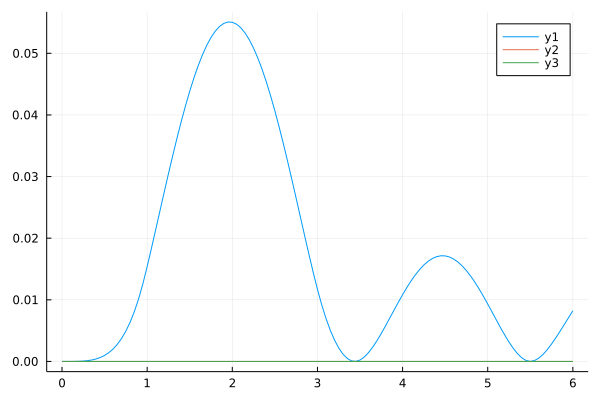

In [23]:
plot(thist, xhist[1,:])
plot!(thist, xhist[2,:])
plot!(thist, xhist[3,:])

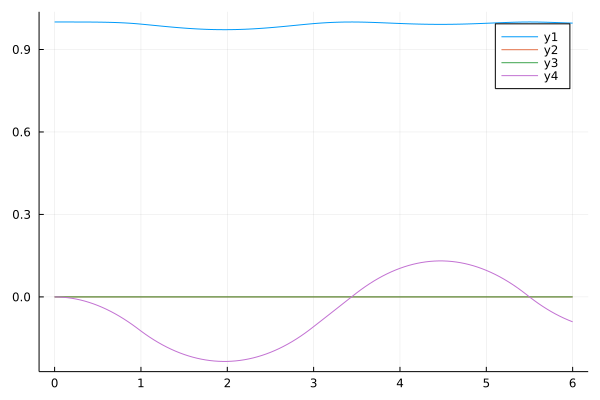

In [24]:
plot(thist, xhist[4,:])
plot!(thist, xhist[5,:])
plot!(thist, xhist[6,:])
plot!(thist, xhist[7,:])

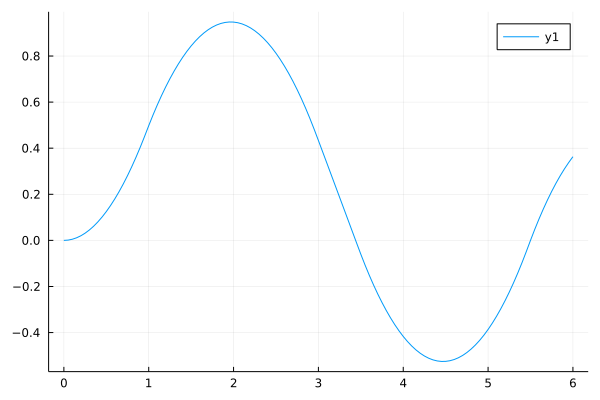

In [25]:
plot(thist, xhist[8,:])

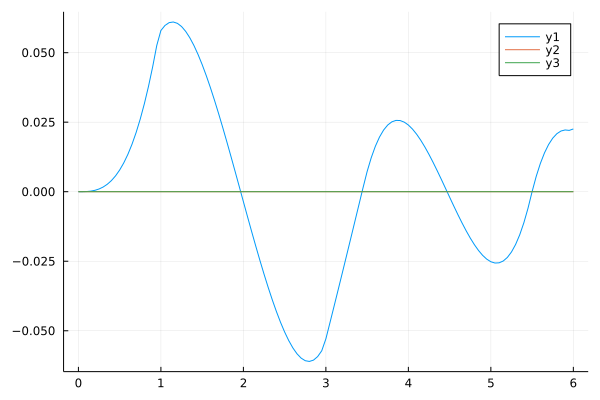

In [26]:
plot(thist, xhist[9,:])
plot!(thist, xhist[10,:])
plot!(thist, xhist[11,:])

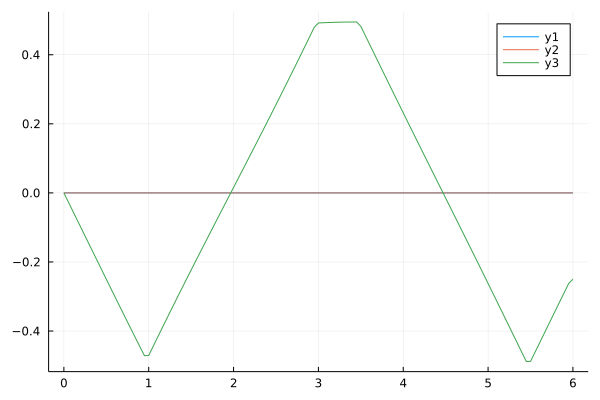

In [27]:
plot(thist, xhist[12,:])
plot!(thist, xhist[13,:])
plot!(thist, xhist[14,:])

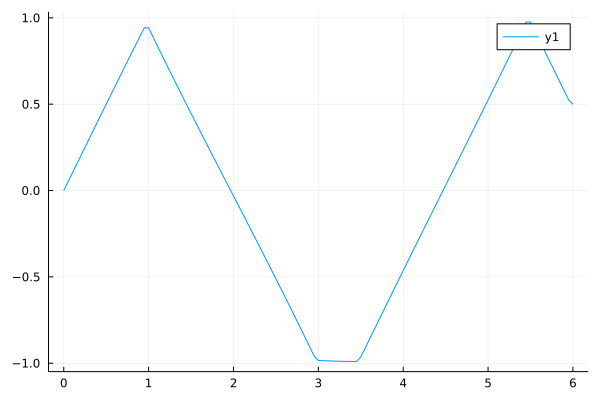

In [28]:
plot(thist, xhist[15,:])

In [29]:
xkn = kinematics(xhist[:,end])

14-element Vector{Float64}:
  0.008224698569490903
 -1.7589898520340513e-9
  0.0
  0.995881580875225
  0.0
  0.0
 -0.09066353662560582
  0.9917849448222267
 -1.7571436805585705e-9
  0.0
  0.9958815808750547
  0.0
  0.0
  0.09066353662747513

In [30]:
xk0 = kinematics(xhist[:,1])

14-element Vector{Float64}:
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0

In [31]:
0.5*(xk0[1:3] + xk0[8:10])

3-element Vector{Float64}:
 0.5
 0.0
 0.0

In [32]:
0.5*(xkn[1:3] + xkn[8:10])

3-element Vector{Float64}:
  0.5000048216958588
 -1.758066766296311e-9
  0.0

In [33]:
using MeshCat, GeometryBasics, CoordinateTransformations, Rotations

In [38]:
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /Users/zac/.julia/packages/MeshCat/RLYij/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8701))

In [39]:
delete!(vis)

green_material = MeshPhongMaterial(color=RGBA(0, 1, 0, 0.8))
cylinder1 = Cylinder(Point(-.5, 0, 0), Point(0.5, 0, 0), 0.1)
setobject!(vis["cylinder1"],cylinder1,green_material)

red_material = MeshPhongMaterial(color=RGBA(1, 0, 0, 0.8))
cylinder2 = Cylinder(Point(-.5, 0, 0), Point(0.5, 0, 0), 0.1)
setobject!(vis["cylinder2"],cylinder2,red_material)

for k = 1:N
    
    Xk = kinematics(xhist[:,k])
    
    # set position and attitude
    position1 = Translation(Xk[1:3]...)
    attitude1 = LinearMap(UnitQuaternion(Xk[4:7]))
    position2 = Translation(Xk[8:10]...)
    attitude2 = LinearMap(UnitQuaternion(Xk[11:14]))
    
    settransform!(vis["cylinder1"], compose(position1,attitude1))
    settransform!(vis["cylinder2"], compose(position2,attitude2))
    sleep(0.05)
end